# State of Charge/State of Health Estimation Framework (SSEF) using Center for Advanced Life Cycle Engineering Data

## Author: Ryley Traverse 

# Modeling

This project focusses on replicating the research found in [this paper](https://www.sciencedirect.com/science/article/abs/pii/S036054422303195X, 'A novel integrated SOC-SOH estimation framework for whole-life-cycle lithium-ion batteries'). 

State of Charge (SOC) is defined as a batteries current amount of remaining capacity available compared to the maximum available capacity of the cell.

State of Health (SOH) is defined as a batteries current maximum available capacity of the cell during cycling compared to the manufacturer's rated capacity.

Estimation of the current charge and health of a battery during cycling (charging/discharging) is critical for battery management systems (BMS) in order to accurately and safely operate lithium ion batteries. Additionally, precise SOH estimation influences accuracy of SOC estimations and contributes to preventing cell events due to untimely battery replacement when high capacity degradation is present. SOC and SOH must be estimated due to challenges in capturing the true capacity of a battery during everyday charging and discharging. There are currently two main non model based approaches to SOC estimation: Open Circuit Voltage (OCV) and Coulomb counting. Coulomb counting has compounding issues to do its cumulative approach and OCV doesn't make sense for real world applications due to necessity of load disconnection.

The approach suggested in this paper is superior to current model based solutions for a multitude of reasons. The first reason is due to the obvious relationship between voltage, current, SOC, and SOH. Current solutions rely on separate models for estimation without considering the increase in performance you can obtain by using a single joint model. Not only can you see an increase in performance of both SOC and SOH estimation with a single model, but, due to parameter sharing and segmented training of the model, the benefits extend to model size, complexity, and efficiency.

In [1]:
# Load all necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
import tensorflow
from tensorflow.keras import Model 
from tensorflow.keras.layers import Dense, Conv1D, Bidirectional, GRU, Input, Concatenate, Masking, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
# Filter unnecessary warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
# Load helper scripts
%load_ext autoreload
%autoreload 2
from src import utils as help_func
from src import plotting_utils as plot_util
from src import config

In [3]:
# Load saved data from data prep
df_subcycle_35 = pd.read_csv('data/calce_subcycle_data_35.csv')
df_subcycle_36 = pd.read_csv('data/calce_subcycle_data_36.csv')
df_subcycle_37 = pd.read_csv('data/calce_subcycle_data_37.csv')
df_subcycle_38 = pd.read_csv('data/calce_subcycle_data_38.csv')
df = pd.read_csv('data/calce_cycling_data.csv')

## Plot Cycling Data on Feature by Feature Basis

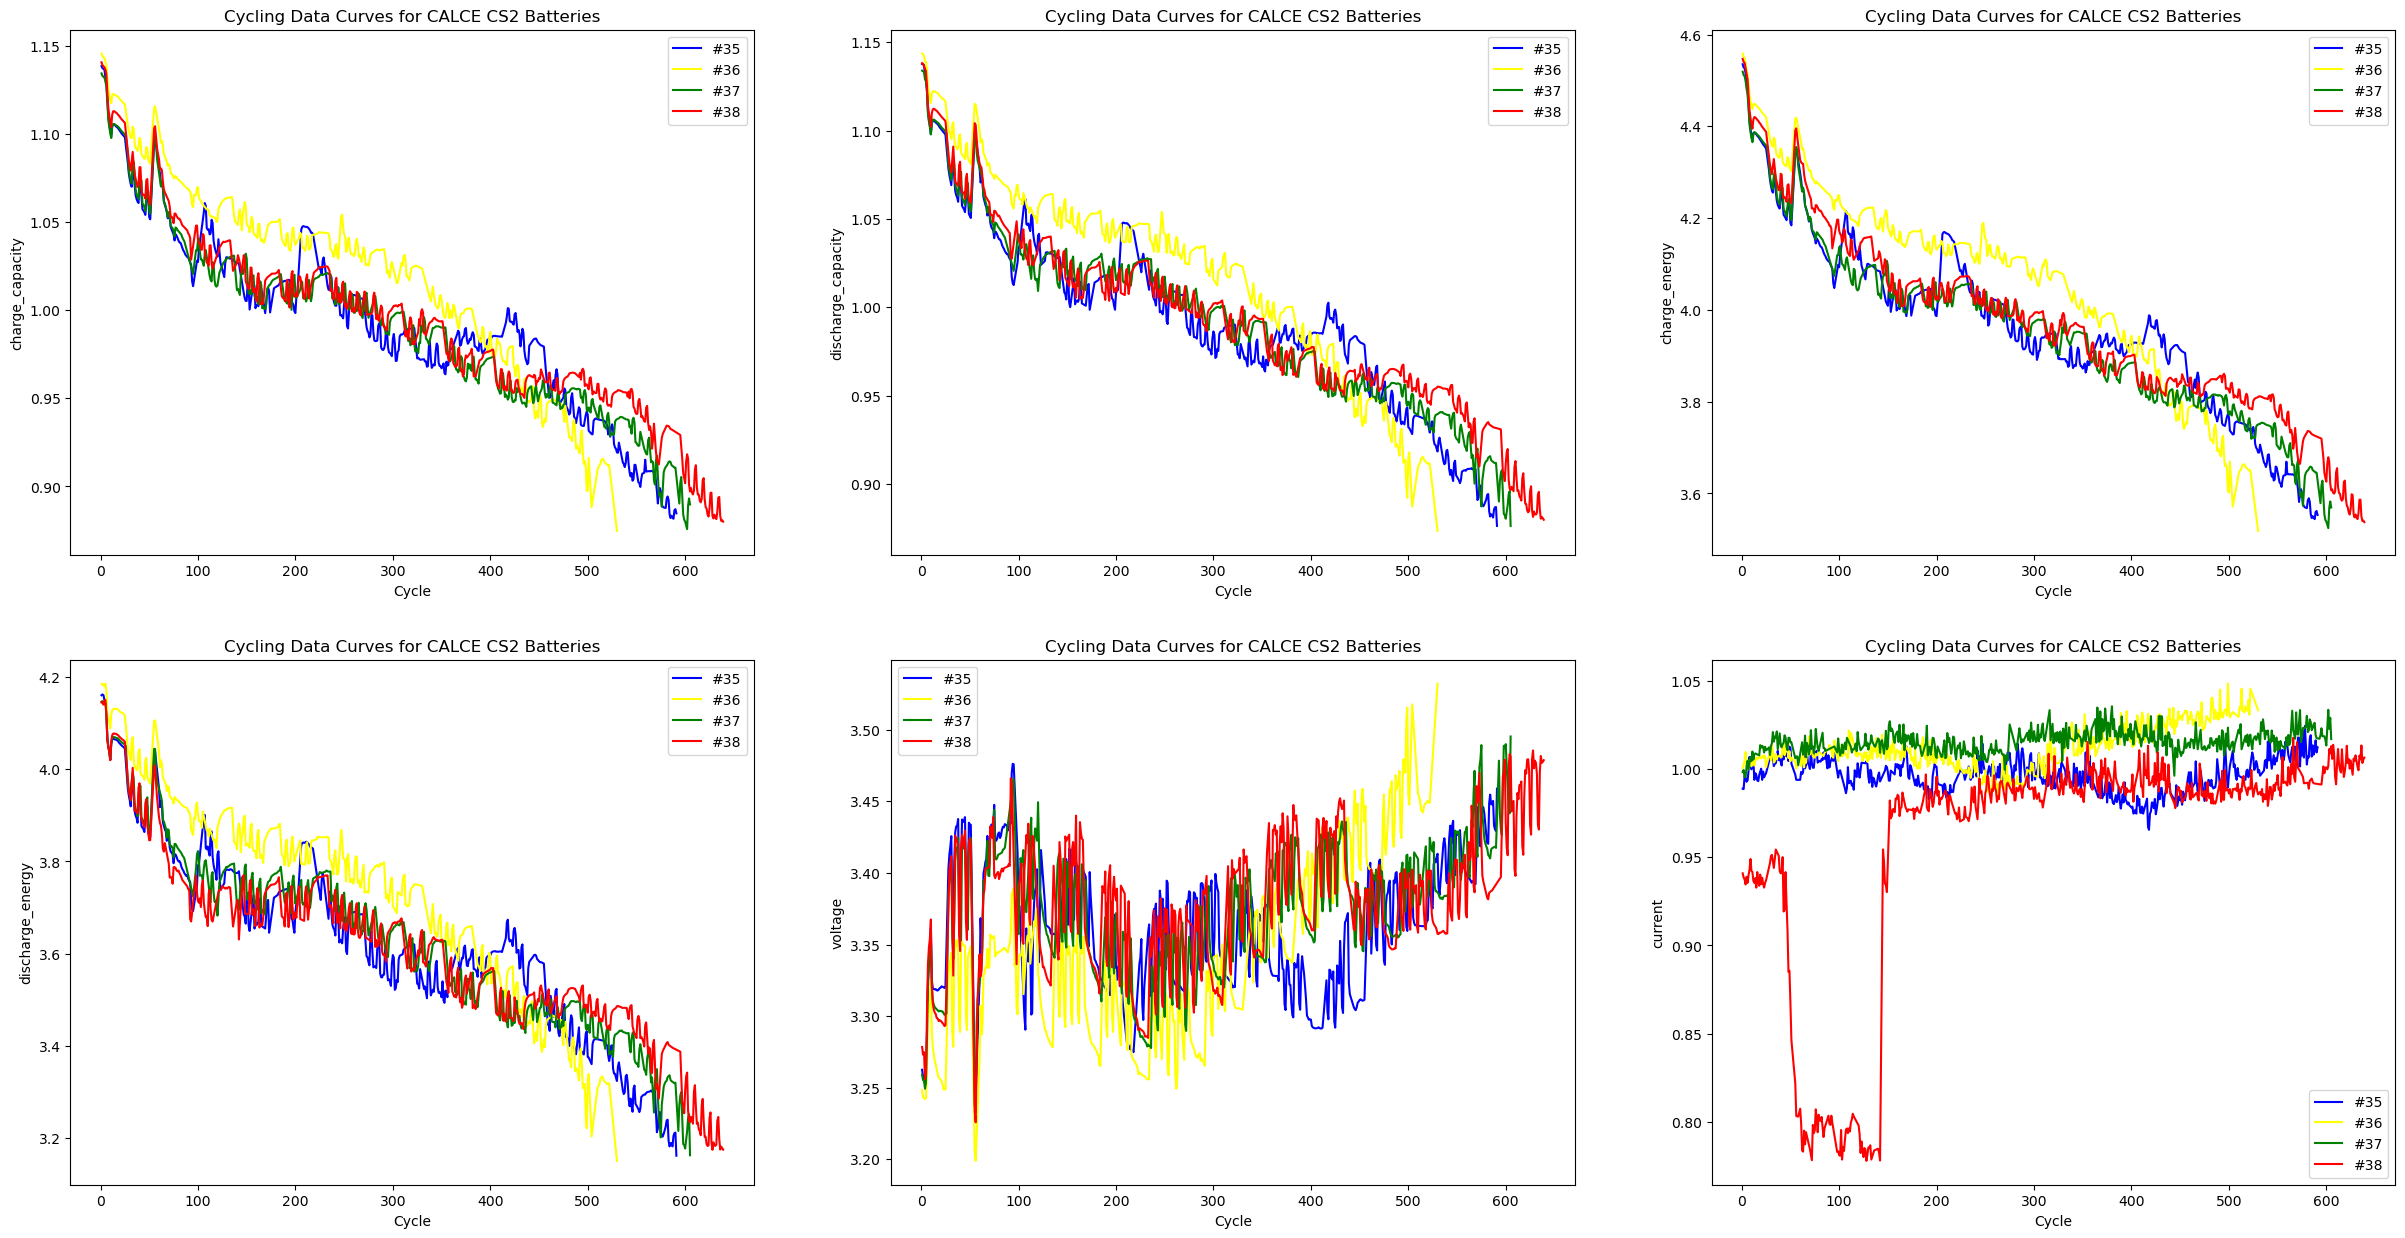

In [5]:
# Plot cycling data's available features after filtering outliers
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
row = 0
col = 0
for feat in config.col_for_filtering:
    axs[row, col].plot(df[df['cell_number'] == 35]['cycle'].to_numpy(), df[df['cell_number'] == 35][feat].to_numpy(), color='blue', label='#35')
    axs[row, col].plot(df[df['cell_number'] == 36]['cycle'].to_numpy(), df[df['cell_number'] == 36][feat].to_numpy(), color='yellow', label='#36')
    axs[row, col].plot(df[df['cell_number'] == 37]['cycle'].to_numpy(), df[df['cell_number'] == 37][feat].to_numpy(), color='green', label='#37')
    axs[row, col].plot(df[df['cell_number'] == 38]['cycle'].to_numpy(), df[df['cell_number'] == 38][feat].to_numpy(), color='red', label='#38')
    if col == 'discharge_capacity':
        axs[row, col].axhline(y=config.nominal_capacity*config.eol, color='black', linestyle='--', label='80% State of Health')
    axs[row, col].legend()
    axs[row, col].set_title('Cycling Data Curves for CALCE CS2 Batteries')
    axs[row, col].set_xlabel('Cycle')
    axs[row, col].set_ylabel(feat)
    if col == 2:
        row = 1
        col = 0
    else:
        col += 1
plt.show()

The above data is comprised of the peak readings from subcycle recordings for each cycle (charge/discharge) for a multitude of features. The peak capacity during charge is what we use to calculate state of health (decreased peak capacity indicates an increase in degradation of the cell). 

Batteries #35, #36, and #38 will make up the training set of the data.

Battery #37 will make up the testing set of the data and will be withheld from training and used to validate the models performance.

## Plot Charge/Discharge Profile

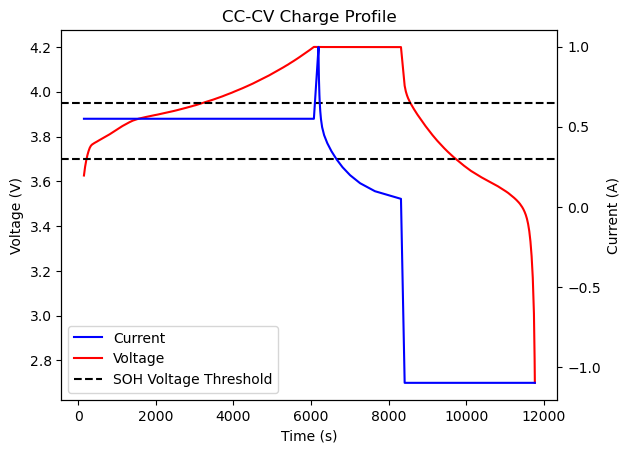

In [8]:
# Plot one cycle of the charge distrubtuion to get an idea of what CC/CV looks like and the voltage range used for SOH
df_subcycle_temp = df_subcycle_35[df_subcycle_35['Cycle_Index'] == 100]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
steps = list(df_subcycle_temp.Step_Index.unique())
ax1.plot(df_subcycle_temp['Test_Time(s)'].to_numpy(), df_subcycle_temp ['Voltage(V)'].to_numpy(), color='red', label='Voltage') 
ax2.plot(df_subcycle_temp['Test_Time(s)'].to_numpy(), df_subcycle_temp['Current(A)'].to_numpy(), color='blue', label='Current') 
ax1.axhline (y=3.7, color = 'black', linestyle= '--', label='SOH Voltage Threshold')
ax1.axhline (y=3.95, color = 'black', linestyle='--')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax2.set_ylabel('Current (A)')
plt.title('CC-CV Charge Profile')
for s in steps:
    df_temp = df_subcycle_temp[df_subcycle_temp['Step_Index']==s]
    max_time = max(df_temp['Test_Time(s)'])
    l = 'End Step' + str(s)
plt.plot([], [], color='red', label='Voltage')
plt.plot([], [], color='black', linestyle='--', label='SOH Voltage Threshold')
plt.legend(loc=3)
plt.show()

The plot above shows a single charge/discharge cycle of voltage and current readings for cell #35. It is a perfect example of constant current/constant voltage charging (CC/CV). The current is fixed at a rate of 0.5 Amps until the voltage hits the threshold of 4.2 Volts. The battery then transitions to the constant voltage phase of decreasing current in order to keep the voltage at 4.2 Volts until the current reaches 0.05 Amps. The battery is then discharged; you can see a fixed current of around -1.0 Amps as well as a gradual drop in voltage.

The SOH Voltage Threshold shown above is the data range used during the charge of the battery for SOH estimation (full cycle readings not required for soh estimation).

## Current/Voltage over Time Colored by Cycle

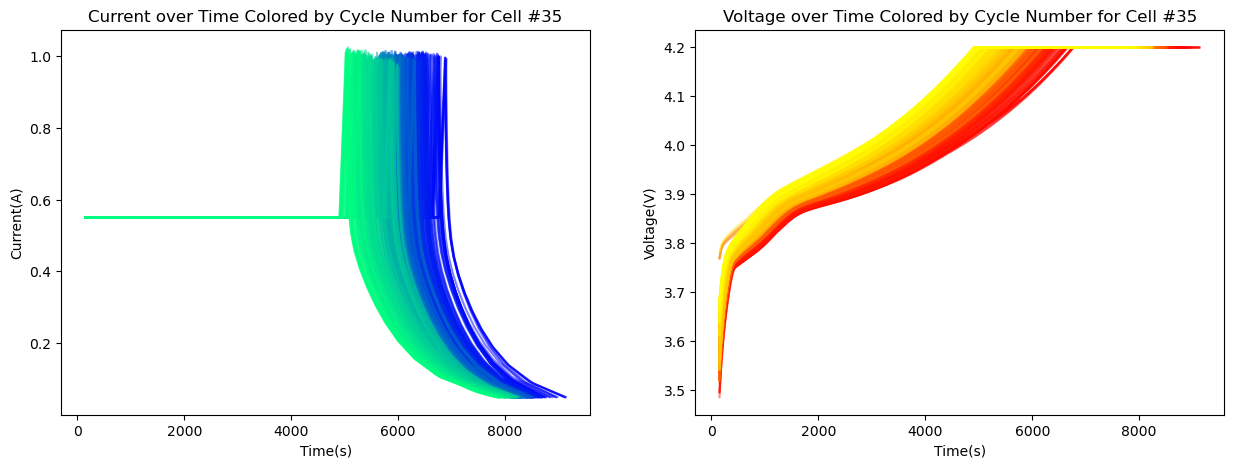

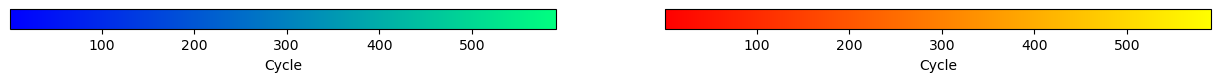

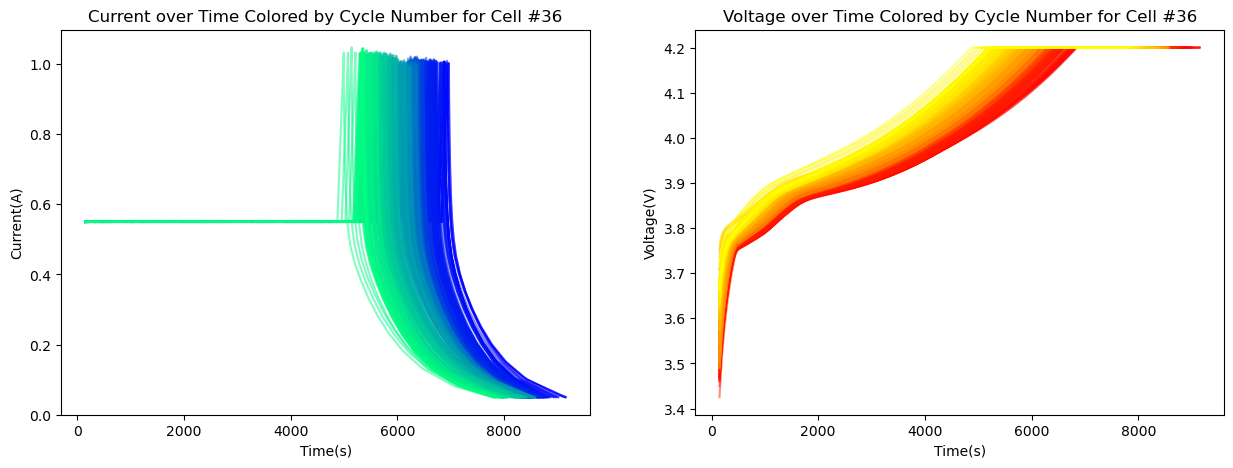

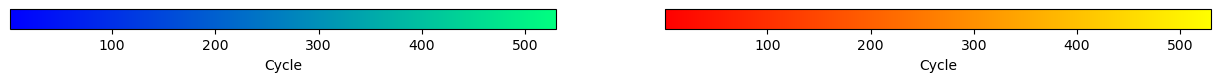

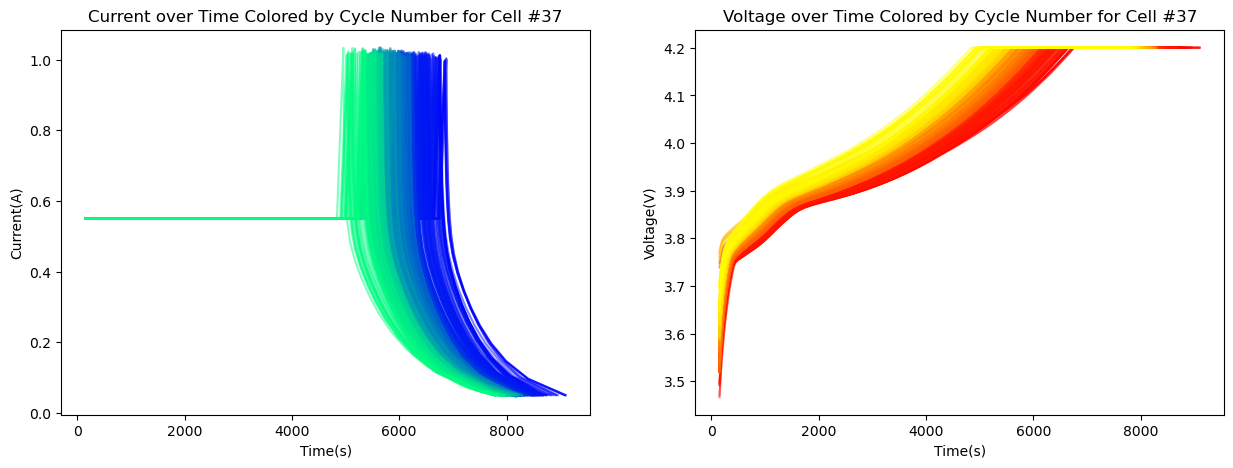

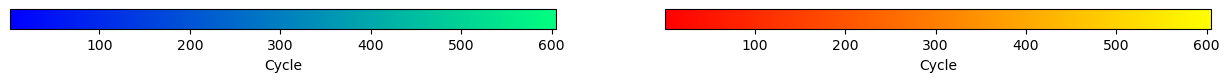

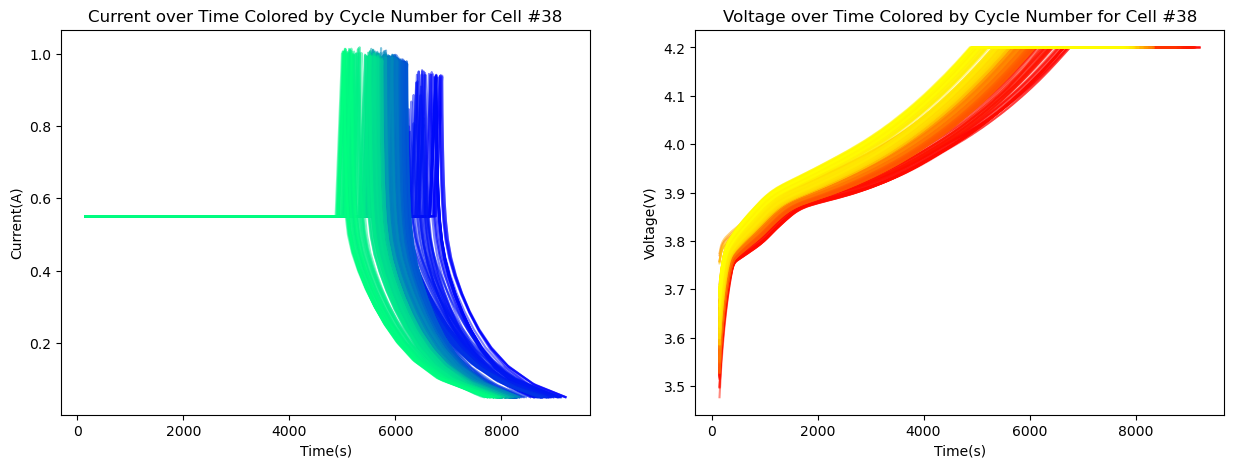

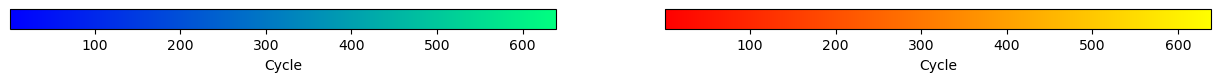

In [42]:
plot_util.plot_subcycle_data(df_subcycle_35, 'Current(A)', 'Voltage(V)', 35)
plot_util.plot_subcycle_data(df_subcycle_36, 'Current(A)', 'Voltage(V)', 36)
plot_util.plot_subcycle_data(df_subcycle_37, 'Current(A)', 'Voltage(V)', 37)
plot_util.plot_subcycle_data(df_subcycle_38, 'Current(A)', 'Voltage(V)', 38)

The plots above do a great job of showing how the charge profile of the battery changes as the battery degrades over time due to cycling. The time it takes for a cell to reach the constant voltage and discharge stages decreases as cycle increases (soh decreases). Overall the amount of time it takes to charge the battery decreases as degradation of the cell due to cycling increases.

## Model Architecture

The SSEF is comprise of four main components:

1. Charge Encoder
2. SOH Encoder
3. SOC Decoder
4. SOH Decoder

The largest portion of the model is the charge encoder. It captures information regarding parameter variations during the charging process. It is comprised of the following layers:

- 1D-CNN 
- TCN
- BiGRU
- TCN
- BiGRU
- Dense

The TCN/BiGRU alternating layers enables the charge encoder to be able to learn both local temporal regions and long term dependencies of the data. The combination of comprehensive local and global feature information allows precise SOC/SOH estimation.

## Model Training

Model training is done in two steps:
1. Train the Charge Encoder and SOH Decoder

![First Round of Training](images/ssef_training1.png)

The first round of training is more focused on learning SOH. A temporary SOC Decoder is utilized so that the Charge Encoder will still learn the relationship between features and SOC in addition to the emphasis on SOH. After this training round, the parameters for the Charge Encoder and SOH Decoder will be frozen for the next round of training that focuses on learning SOC. The data for the first round of training is mainly comprised of the constant current charge stage Voltage and Current readings in the SOH voltage range. Several cycles worth of full charge/discharge readings are included so the Charge Encoder can learn full cycle SOC information before being frozen.

2. Train the SOH Encoder and SOC Decoder

![Second Round of Training](images/ssef_training2.png)

This round of training is more focused on learning SOC from Voltage, Current, and SOH. The actual SOH readings are put through a Gaussian Noise layer before being sent to SOC Decoder to replicate the inherent error in SOH estimation for final modeling. The data for the second round of training is comprised of full cycle data (not just in voltage range) sampled at every 50 cycles (training using every cycles data is overkill).

![Final Model](images/ssef_final_model.png)

SOH input will be padded in final model if the charge data hasn't reached the 3.7-3.95V range used for SOH estimation.


## Get Numpy Matrices for First Round SOH Focused Model Training

In [43]:
# Define features used in model
features = ['Current(A)', 'Voltage(V)']
# Initialize and fit data scaler using training data
scaler = StandardScaler()
df_train = pd.concat([df_subcycle_35, df_subcycle_36, df_subcycle_38])
scaler.fit(df_train[features])
# Whether to add data in voltage range for soh training in returned numpy matrix
add_soh = True
# Whether to add full cycle data for soc training in returned numpy matrix
add_soc = True
# Set Data Sequence Length
seq_len = 80
# Set bounds for soh voltage range
soh_lower_bound = 3.7
soh_upper_bound = 3.95
# How many observations to skip between soh measurements in voltage range for same cycle
soh_break = 5
# Which cycle numbers of full data soc training we want to use
soc_cycle_list = [10, 250, 500]
# Get results dataframe and X, y_soh, and y_soc numpy arrays for training model
df_soh_35, X_35, y_soh_35, y_soc_35 = help_func.get_X_y_soh(df_subcycle_35, scaler, features, add_soh, add_soc, seq_len, soh_lower_bound, soh_upper_bound, soc_cycle_list, soh_break)
df_soh_36, X_36, y_soh_36, y_soc_36 = help_func.get_X_y_soh(df_subcycle_36, scaler, features, add_soh, add_soc, seq_len, soh_lower_bound, soh_upper_bound, soc_cycle_list, soh_break)
df_soh_38, X_38, y_soh_38, y_soc_38 = help_func.get_X_y_soh(df_subcycle_38, scaler, features, add_soh, add_soc, seq_len, soh_lower_bound, soh_upper_bound, soc_cycle_list, soh_break)
df_soh_train = pd.concat([df_soh_35, df_soh_36, df_soh_38])
X_train = np.concatenate((X_35, X_36, X_38))
y_train_soh = np.concatenate((y_soh_35, y_soh_36, y_soh_38))
y_train_soc = np.concatenate((y_soc_35, y_soc_36, y_soc_38))
df_soh_test, X_test, y_test_soh, y_test_soc = help_func.get_X_y_soh(df_subcycle_37, scaler, features, add_soh, add_soc, seq_len, soh_lower_bound, soh_upper_bound, soc_cycle_list, soh_break)

## Define SSEF Layers and Create Model

In [51]:

charge_encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), name='Input')
CNN_1D = Conv1D(50, 3, activation = 'relu', name='1D_CNN')
TCN_1 = Conv1D(50, 3, dilation_rate=20, activation = 'relu', padding = "causal", name='TCN_1')
BIGRU_1 = Bidirectional(GRU(100, activation='relu', return_sequences=True, return_state=True), merge_mode='concat', name='BiGRU_1')
TCN_2= Conv1D(50, 3, dilation_rate=20, activation = 'relu', padding = "causal", name='TCN_2') 
BIGRU_2 = Bidirectional(GRU(100, activation='relu'), name='BIGRU_2')
concat_state = Concatenate(name='Concat_BiGRU_states')
dense_charge_encoder = Dense(50, activation = 'relu', name='Dense_Charge_Encoder')
soh_decoder = Dense(10, name='Dense_SOH_Decoder')
soh_output=Dense(1, name='SOH_Output')
temp_soc_decoder = Dense(10, name='Dense_Temp_SOC_Decoder')
temp_soc_output = Dense(1, name='SOC_Temp_Output')

x = CNN_1D(charge_encoder_inputs)
x = TCN_1(x)
x_seq, x_state_forwards, x_state_backwards = BIGRU_1(x)
x = TCN_2(x_seq)
x = BIGRU_2(x)
x = concat_state([x_state_forwards, x_state_backwards, x])
x = dense_charge_encoder(x)
x_soh = soh_decoder(x)
output_soh = soh_output(x_soh)
x_soc_temp = temp_soc_decoder(x)
output_temp_soc = temp_soc_output(x_soc_temp)

soh_model = Model(inputs=[charge_encoder_inputs], outputs=[output_soh, output_temp_soc], name='functional_soh_model')

## Plot SSEF Visual

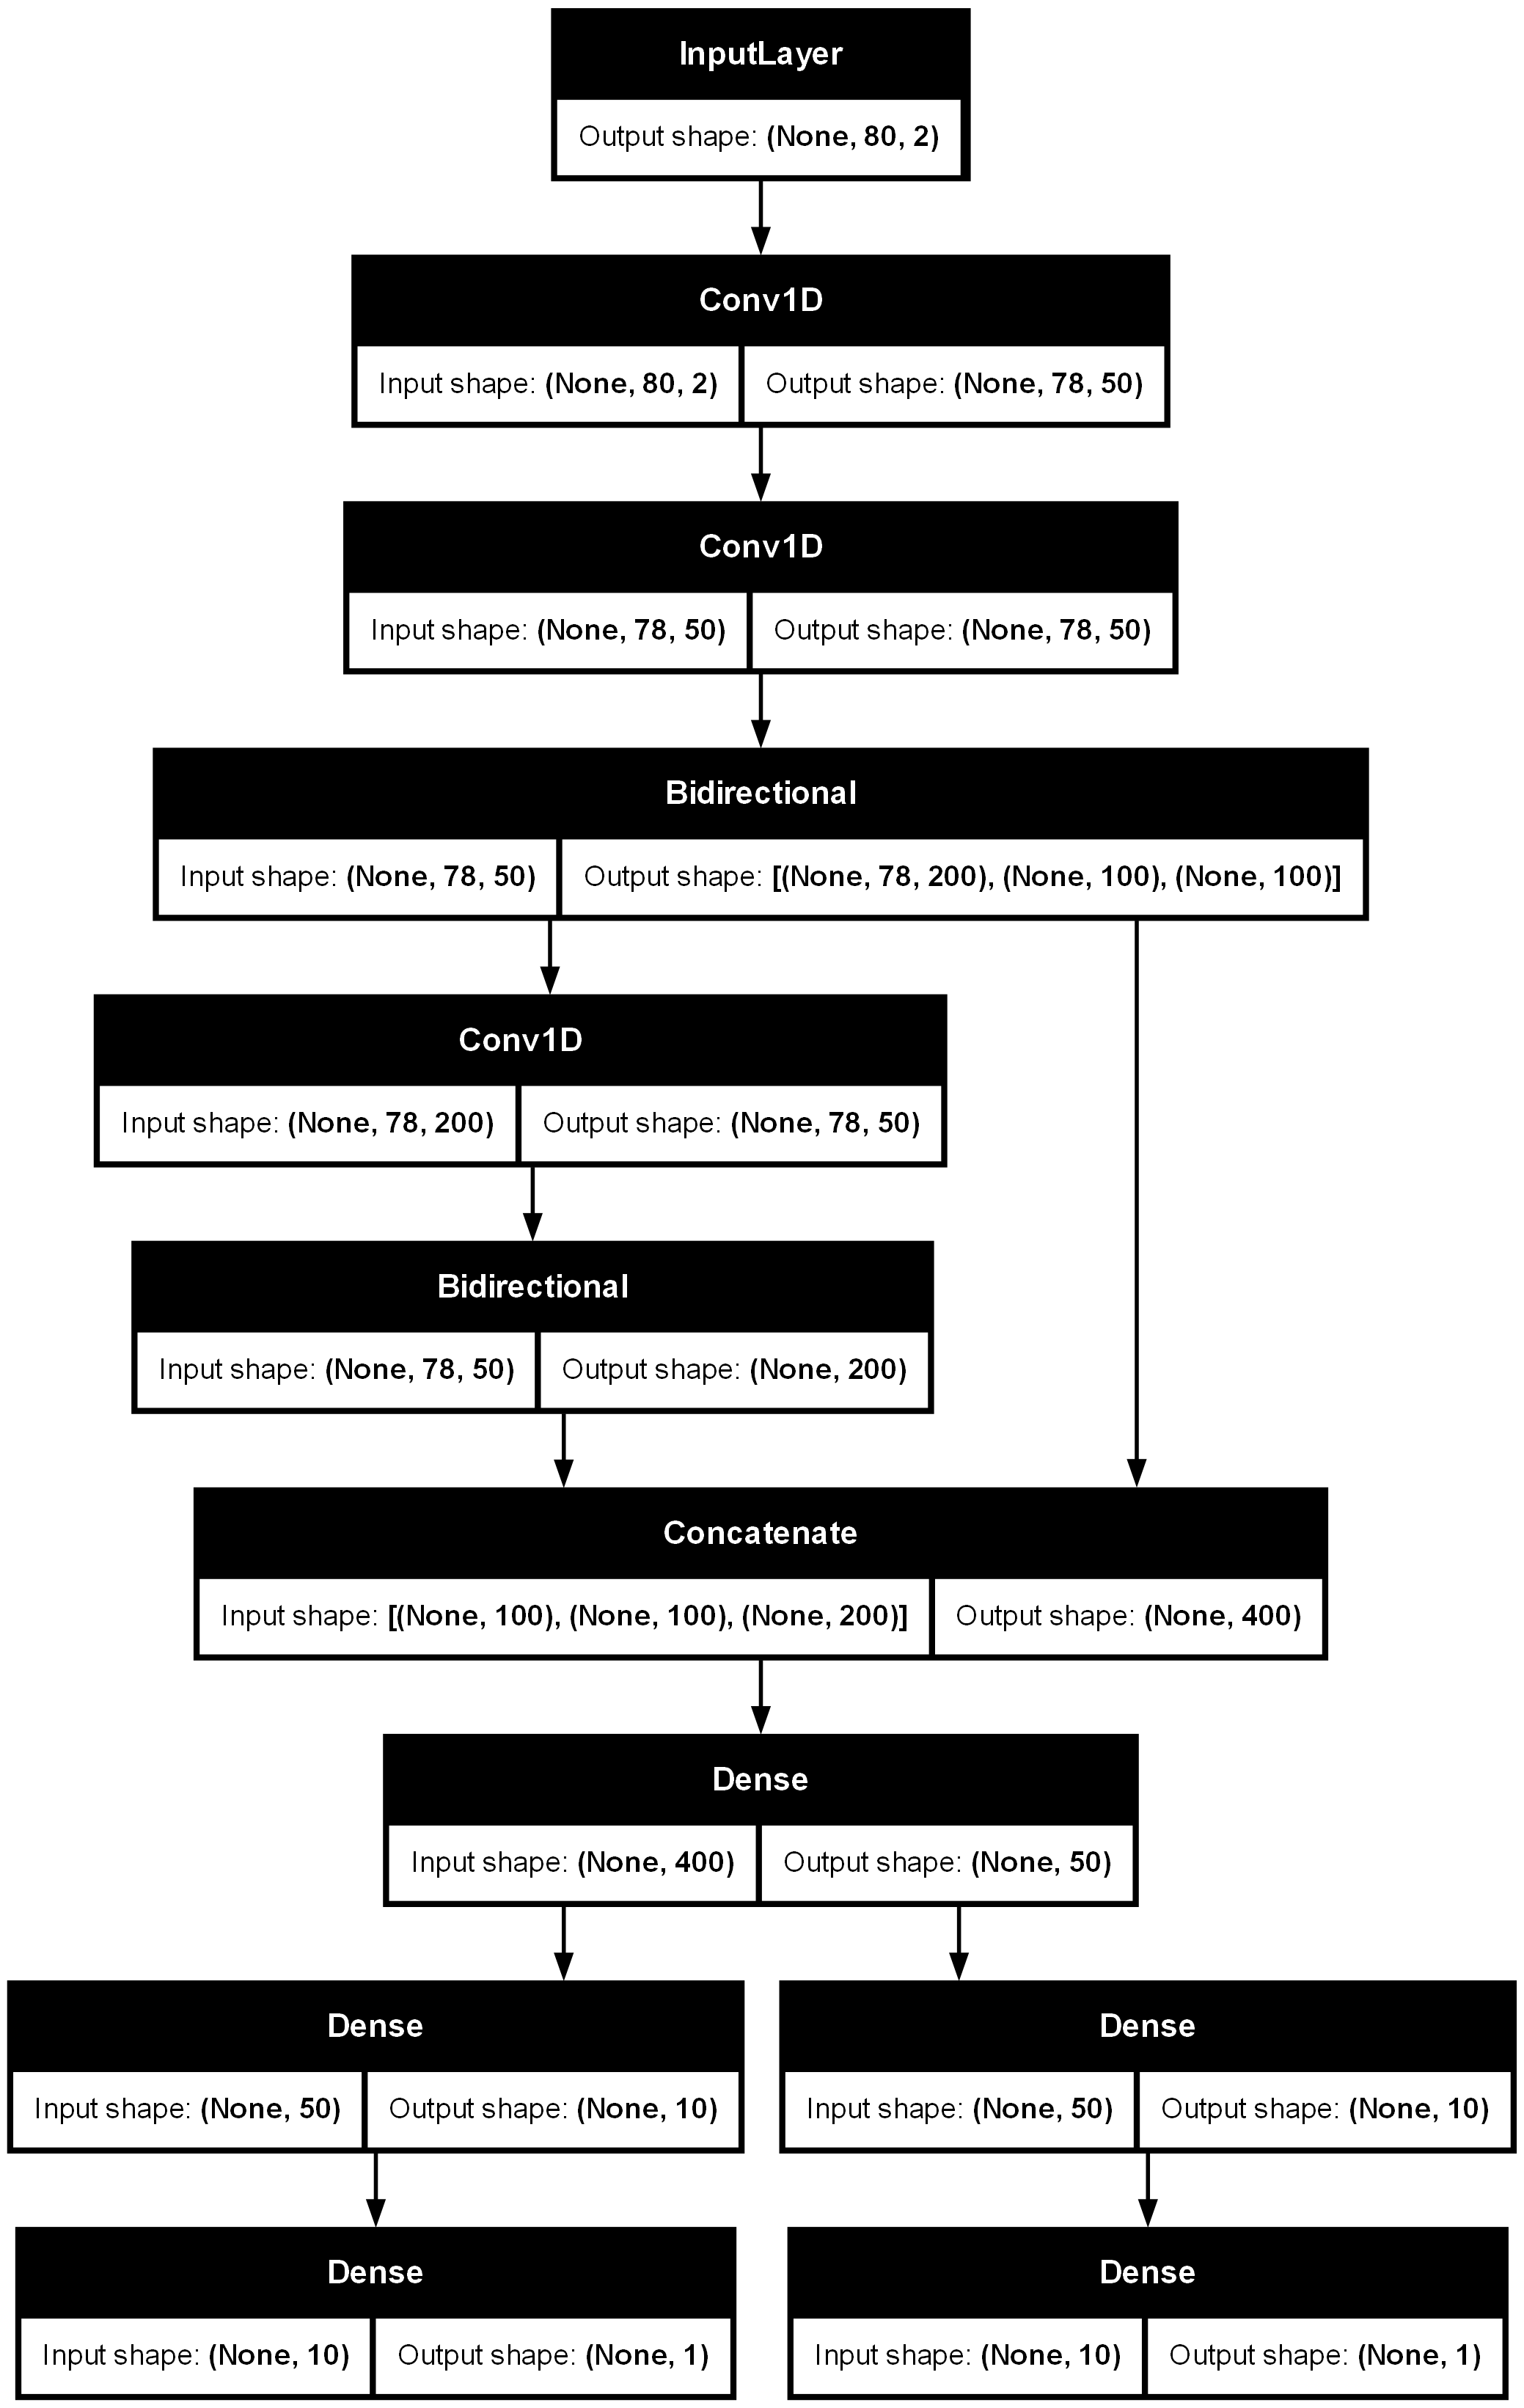

In [52]:
tensorflow.keras.utils.plot_model(soh_model, 'images/ssef_soh.png', show_shapes=True)

## First Round Model Training

Notice the weight put on learning soh in this first round of training (SOH focused)

In [48]:
es = EarlyStopping(monitor='val_loss', patience=30, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000000001, patience=15)
soh_loss_weight = 0.8
soc_loss_weight = 0.2
soh_model.compile(loss=tensorflow.keras.losses.MeanAbsoluteError(),
                  optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), 
                  loss_weights=[soh_loss_weight, soc_loss_weight],
                  metrics=[tensorflow.keras.metrics.MeanAbsoluteError(), tensorflow.keras.metrics.MeanSquaredError()])
history = soh_model.fit(X_train, [y_train_soh, y_train_soc], epochs=300, batch_size=2250, callbacks=[es, reduce_lr], validation_data=(X_test, [y_test_soh, y_test_soc]), verbose=0)

## SOH Prediction Results

136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step
SOH Prediction Accuracy:
Mean Absolute Error: 0.009043364431407505
Root Mean Squared Error: 0.011064198882016475
Median Absolute Error: 0.007994834808094264
R Squared: 0.9318398368536588



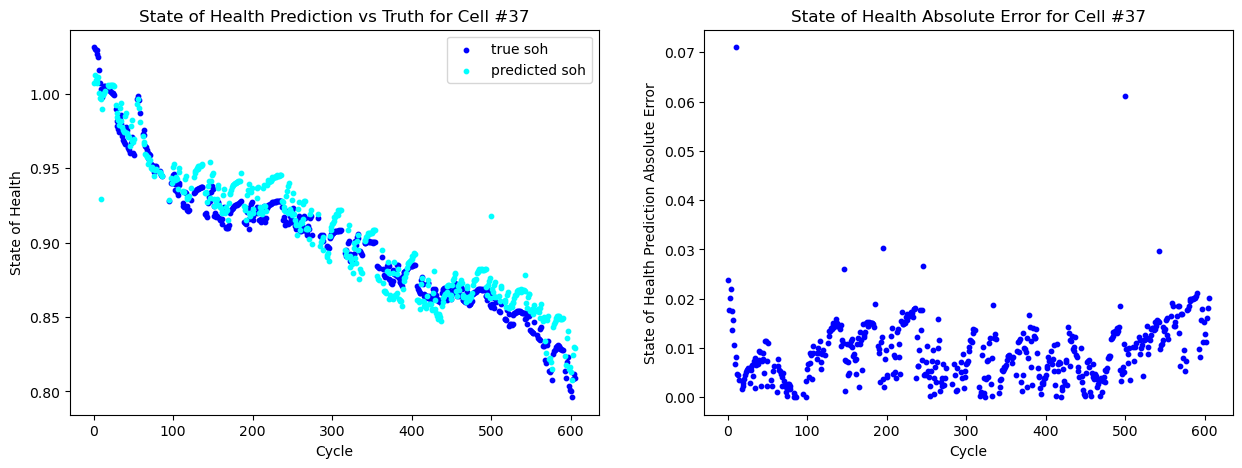

In [7]:
soh_pred, soc_pred = soh_model.predict(X_test)
df_soh_test['soh_prediction'] = soh_pred
df_soh_test['soc_prediction'] = soc_pred
plot_util.print_results(df_soh_test, False, True)
plot_util.plot_soh_stuff(df_soh_test)

The print out above shows the performance of the model when predicting State of Health on Cell #37 (Not used to train model)

Mean Absolute Error = 0.84%-pts 

Root Mean Squared Error = 1.02%-pts

The plot showing predicted vs actual soh shows the predictions to be fairly accurate besides several cycles. You can see this same pattern mirrored in the absolute error of state of health predictions as it rarely goes above 0.02.

## Get Numpy Matrices for Second Round SOC Focused Model Training

In [33]:
add_soh = False
add_soc = True
seq_len = 80
soc_cycle_list = range(2, 603, 50)
df_soc_35, X_35, y_soh_35, y_soc_35 = help_func.get_X_y_soh(df_subcycle_35, scaler, features, add_soh, add_soc, seq_len, soh_lower_bound, soh_upper_bound, soc_cycle_list, soh_break)
df_soc_36, X_36, y_soh_36, y_soc_36 = help_func.get_X_y_soh(df_subcycle_36, scaler, features, add_soh, add_soc, seq_len, soh_lower_bound, soh_upper_bound, soc_cycle_list, soh_break)
df_soc_38, X_38, y_soh_38, y_soc_38 = help_func.get_X_y_soh(df_subcycle_38, scaler, features, add_soh, add_soc, seq_len, soh_lower_bound, soh_upper_bound, soc_cycle_list, soh_break)
df_soc_train = pd.concat([df_soc_35, df_soc_36, df_soc_38])
X_train = np.concatenate((X_35, X_36, X_38))
y_train_soh = np.concatenate((y_soh_35, y_soh_36, y_soh_38))
y_train_soc = np.concatenate((y_soc_35, y_soc_36, y_soc_38))
df_soc_test, X_test, y_test_soh, y_test_soc = help_func.get_X_y_soh(df_subcycle_37, scaler, features, add_soh, add_soc, seq_len, soh_lower_bound, soh_upper_bound, soc_cycle_list, soh_break)

## Remove Temporary SOC Decoder from SOH Model and Freeze Parameters

In [34]:
truncated_soh_model = Model(inputs=soh_model.layers[1].input, outputs=soh_model.layers[10].output, name='truncated_soh_model')
truncated_soh_model.trainable = False
truncated_soh_model.summary()

Model: "truncated_soh_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 80, 2)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 1D_CNN (Conv1D)     │ (None, 78, 50)    │        350 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TCN_1 (Conv1D)      │ (None, 78, 50)    │      7,550 │ 1D_CNN[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiGRU_1             │ [(None, 78, 200), │     91,200 │ TCN_1[0][0]       │
│ (Bidirectional)     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TCN_2 (Conv1D)      │ (None, 78, 50)    │     30,050 │ BiGRU_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BIGRU_2             │ (None, 200)       │     91,200 │ TCN_2[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat_BiGRU_States │ (None, 400)       │          0 │ BiGRU_1[0][1],    │
│ (Concatenate)       │                   │            │ BiGRU_1[0][2],    │
│                     │                   │            │ BIGRU_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Charge_Encod… │ (None, 50)        │     20,050 │ Concat_BiGRU_Sta… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_SOH_Decoder   │ (None, 10)        │        510 │ Dense_Charge_Enc… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SOH_Output (Dense)  │ (None, 1)         │         11 │ Dense_SOH_Decode… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 240,921 (941.10 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 240,921 (941.10 KB)

## Calcualte SOH Prediction Standard Deviation to Add SOH Encoder and SOC Decoder to Model

In [35]:
df_soh_test_soh_only = df_soh_test[df_soh_test['for_soc'] == False]
soh_pred_std = np.std(abs(df_soh_test_soh_only['soh'] - df_soh_test_soh_only['soh_prediction']))

# Define Layers
ouput_charge_encoder = truncated_soh_model.get_layer('Dense_Charge_Encoder').output 
input_tunc_model = truncated_soh_model.input
#SOH Encoder
soh_encoder_inputs = Input(shape=(1,), name='SOH_Input')
gaussian_noise = GaussianNoise(soh_pred_std, name='Gaussian_Noise') 
dense_soh_encoder = Dense(10, name='Dense_SOH_Encoder')
#SOC Decoder
concat_soh = Concatenate (axis=-1, name='Concat_SOH')
soc_decoder1 =  Dense(50, name='Dense_SOC_Decoder1') 
soc_decoder2 = Dense(10, name='Dense_SOC_Decoder2') 
soc_output = Dense(1, name='SOC_Output')

#SOH Encoder
x_soh_true = gaussian_noise(soh_encoder_inputs)
x_soh_true = dense_soh_encoder(x_soh_true)
#SOC Decoder
x_soc = concat_soh([ouput_charge_encoder, x_soh_true])
x_soc=soc_decoder1(x_soc)
x_soc=soc_decoder2(x_soc)
output_soc = soc_output (x_soc)

soc_model = Model(inputs=[input_tunc_model, soh_encoder_inputs], outputs=output_soc, name='functional_soc_model')
soc_model.summary()

Model: "functional_soc_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 80, 2)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 1D_CNN (Conv1D)     │ (None, 78, 50)    │        350 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TCN_1 (Conv1D)      │ (None, 78, 50)    │      7,550 │ 1D_CNN[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiGRU_1             │ [(None, 78, 200), │     91,200 │ TCN_1[0][0]       │
│ (Bidirectional)     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TCN_2 (Conv1D)      │ (None, 78, 50)    │     30,050 │ BiGRU_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BIGRU_2             │ (None, 200)       │     91,200 │ TCN_2[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SOH_Input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat_BiGRU_States │ (None, 400)       │          0 │ BiGRU_1[0][1],    │
│ (Concatenate)       │                   │            │ BiGRU_1[0][2],    │
│                     │                   │            │ BIGRU_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Gaussian_Noise      │ (None, 1)         │          0 │ SOH_Input[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Charge_Encod… │ (None, 50)        │     20,050 │ Concat_BiGRU_Sta… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_SOH_Encoder   │ (None, 10)        │         20 │ Gaussian_Noise[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat_SOH          │ (None, 60)        │          0 │ Dense_Charge_Enc… │
│ (Concatenate)       │                   │            │ Dense_SOH_Encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_SOC_Decoder1  │ (None, 50)        │      3,050 │ Concat_SOH[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_SOC_Decoder2  │ (None, 10)        │        510 │ Dense_SOC_Decode… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SOC_Output (Dense)  │ (None, 1)         │         11 │ Dense_SOC_Decode… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 243,991 (953.09 KB)

 Trainable params: 3,591 (14.03 KB)

 Non-trainable params: 240,400 (939.06 KB)

## Plot SSEF Visual

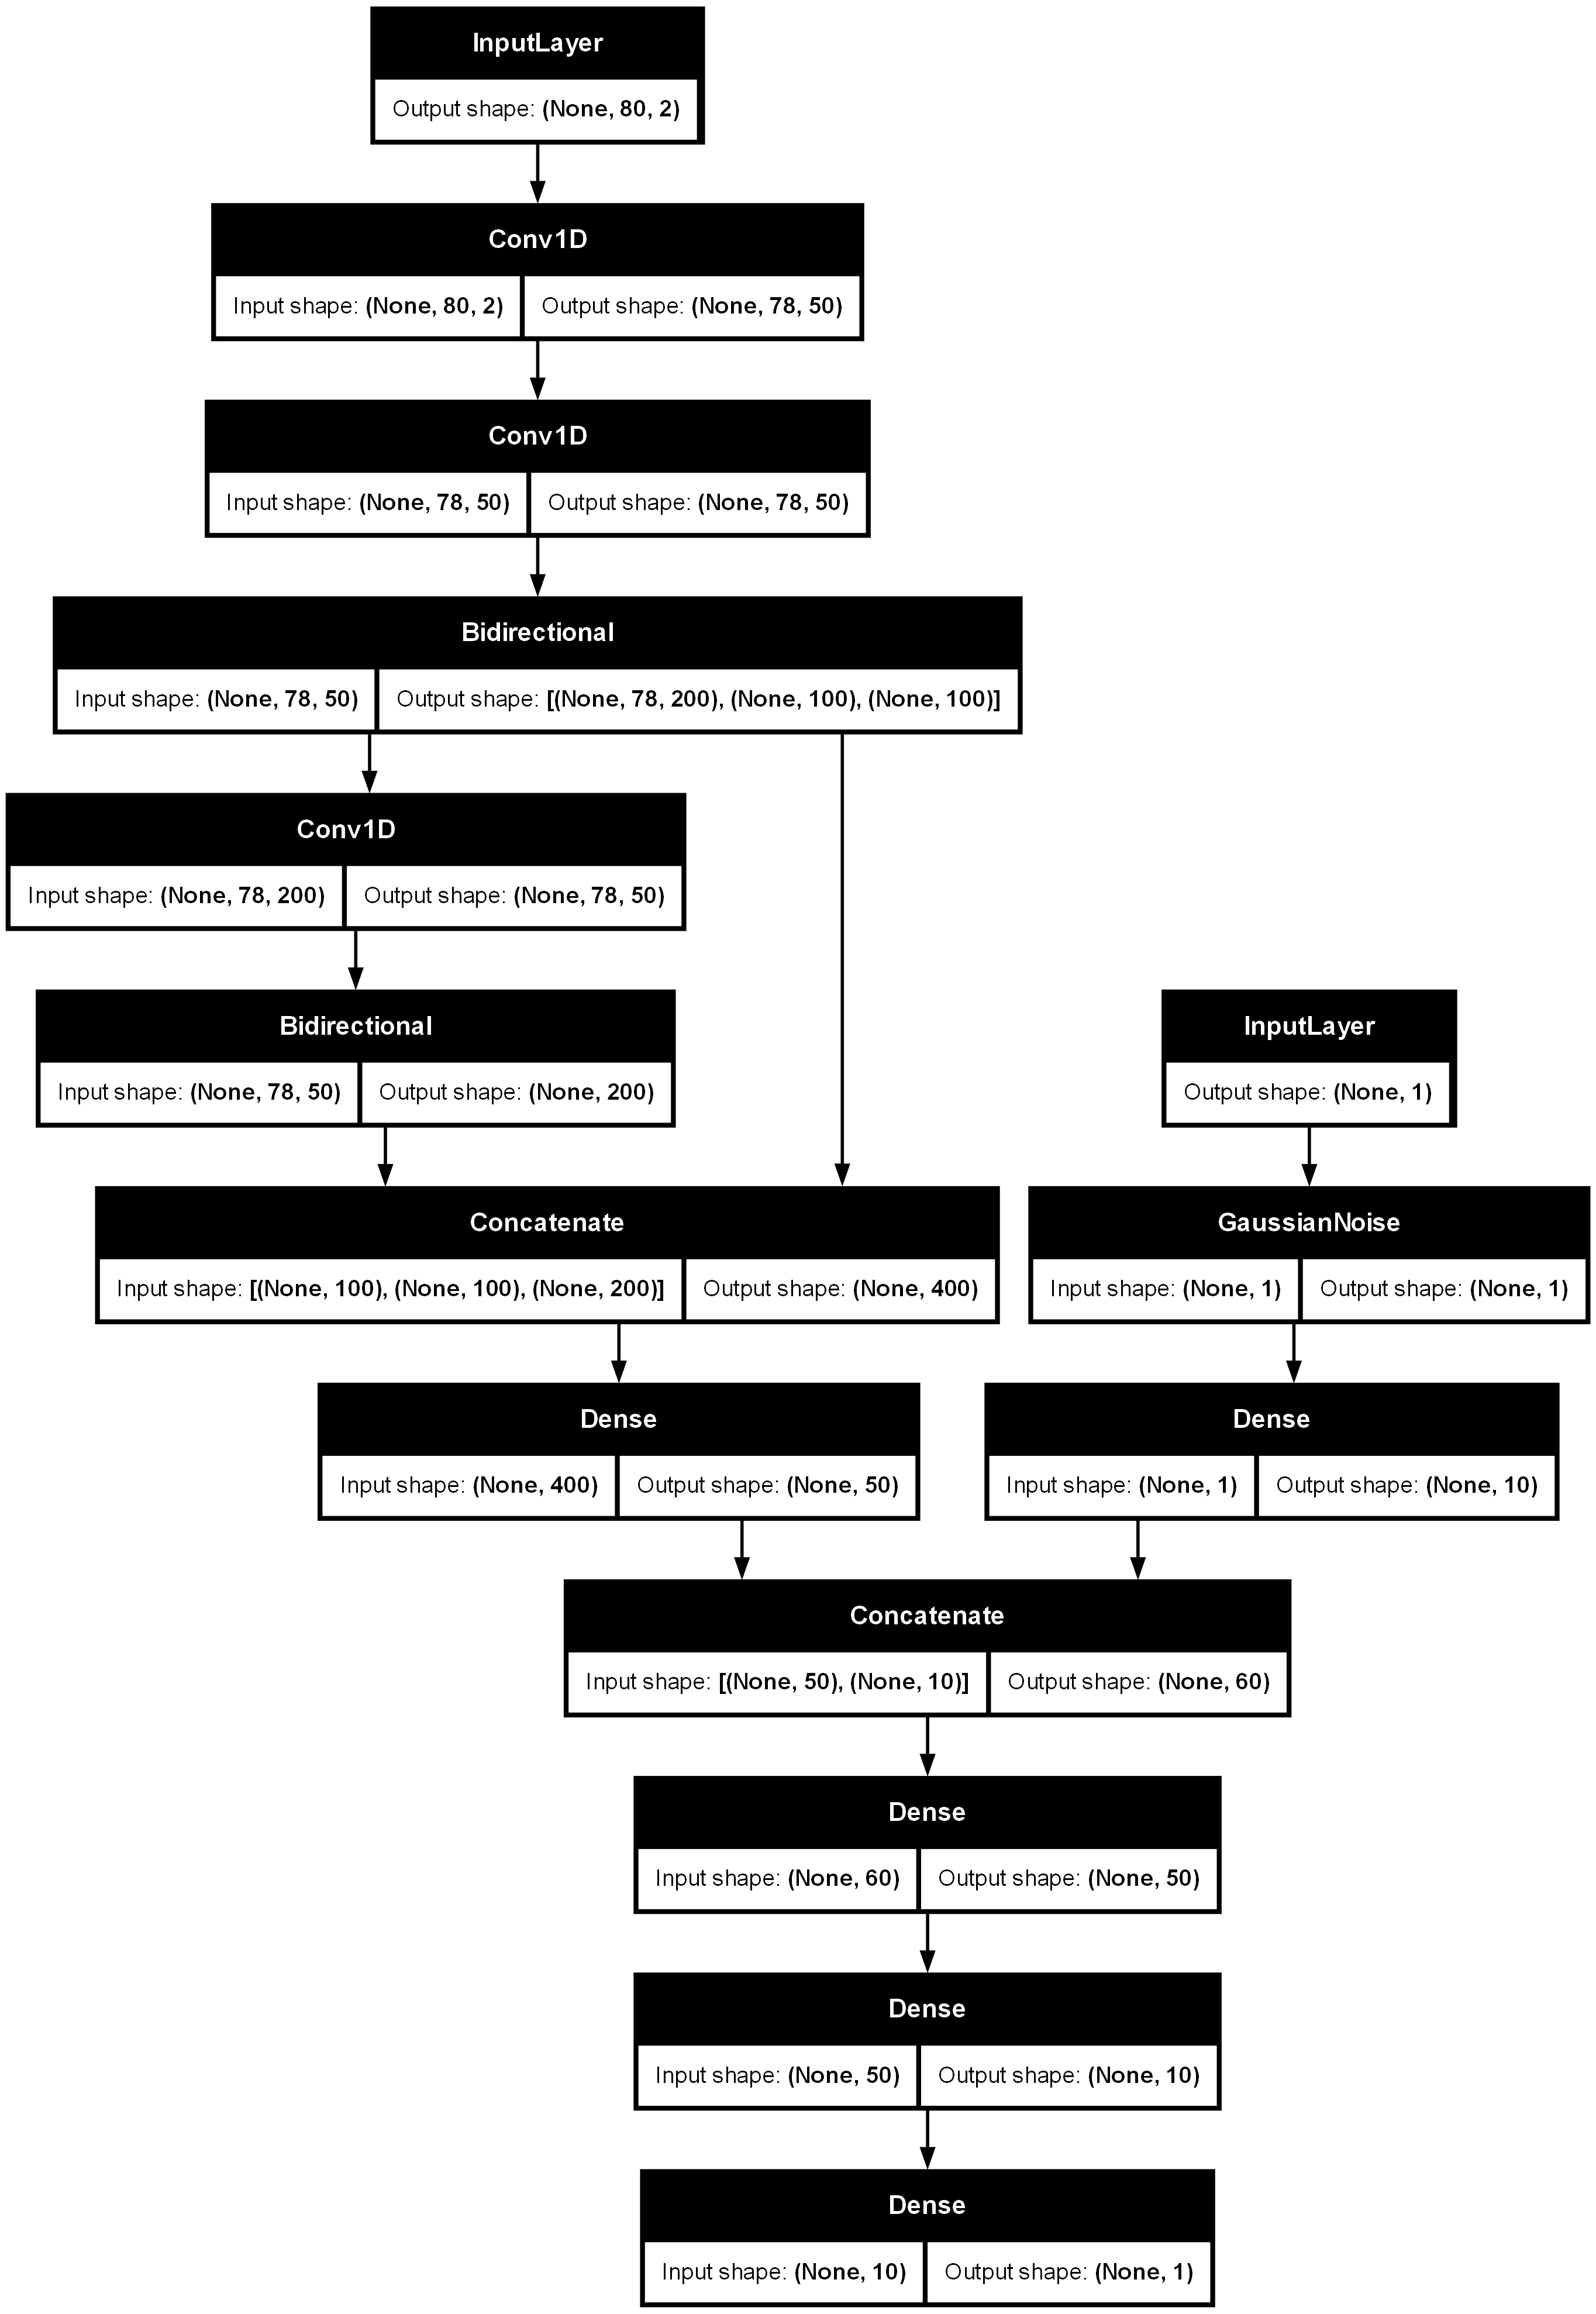

In [36]:
tensorflow.keras.utils.plot_model(soc_model, 'images/ssef_soc.png', show_shapes=True)

## Second Round Model Training

In [37]:
es = EarlyStopping(monitor='val_loss', patience=30, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000000001, patience=15)

truncated_soh_model.compile(loss=tensorflow.keras.losses.MeanAbsoluteError(),
                  optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=[tensorflow.keras.metrics.MeanSquaredError()])

soc_model.compile(loss=tensorflow.keras.losses.MeanAbsoluteError(),
                  optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=[tensorflow.keras.metrics.MeanSquaredError()])

history = soc_model.fit([X_train, y_train_soh],  y_train_soc, epochs=300, batch_size=2500, callbacks=[es, reduce_lr], validation_data=([X_test, y_test_soh], y_test_soc), verbose=0)

## SOC Prediction Results

109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
SOC Prediction Accuracy:
Mean Absolute Error: 0.058479767313766896
Root Mean Squared Error:  0.07594710746939742
Median Absolute Error: 0.052268862265032884
R Squared: 0.9277269147402858


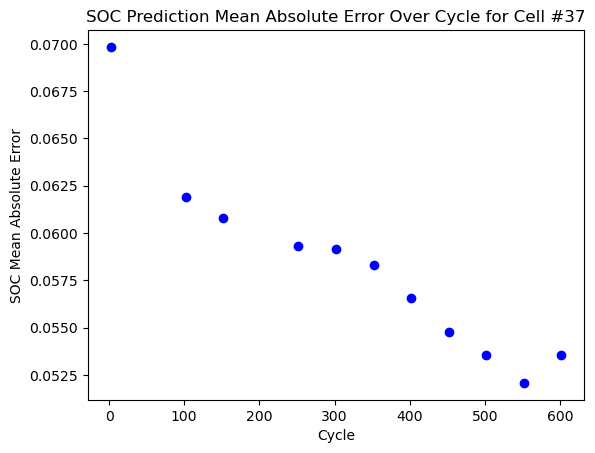

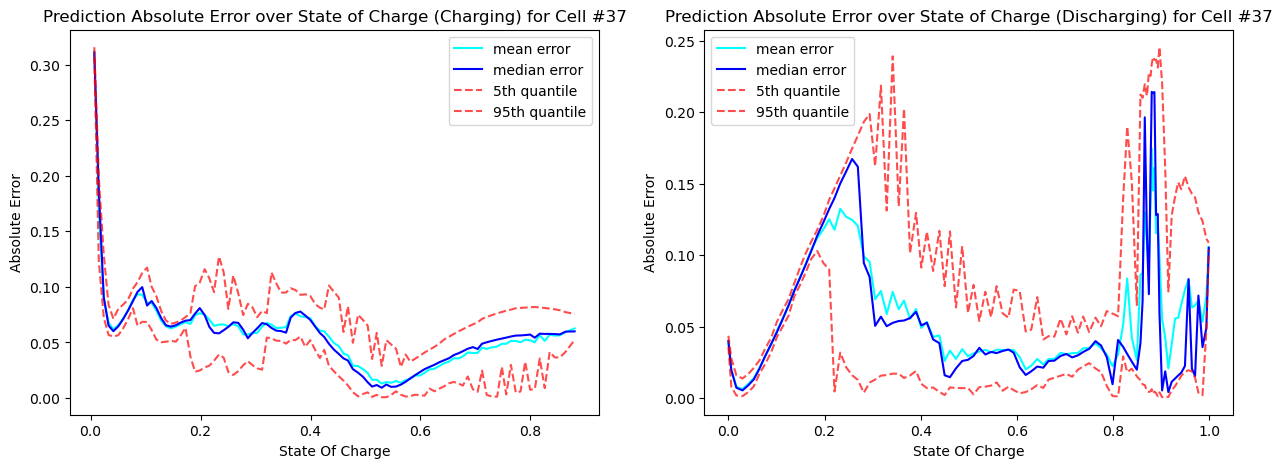

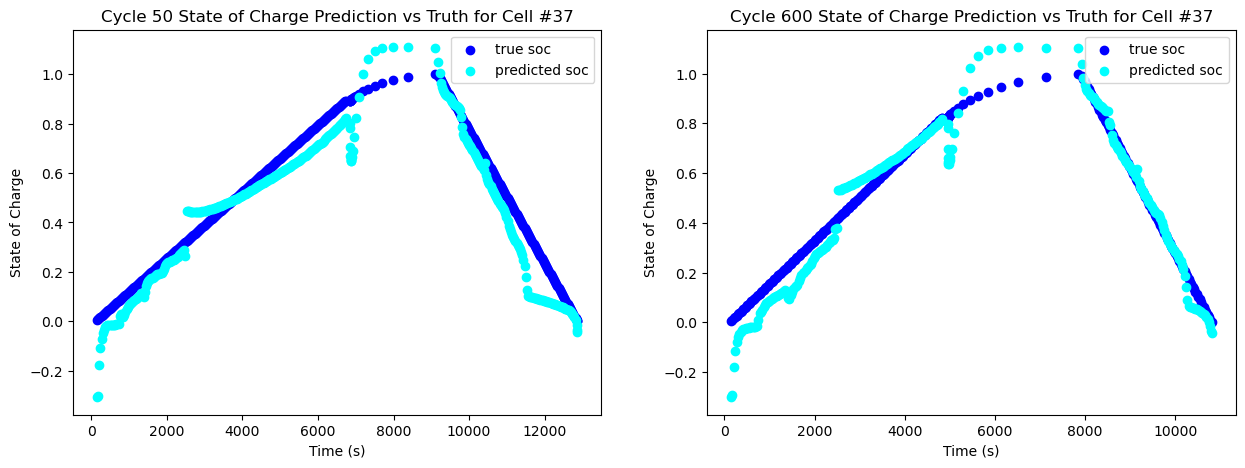

In [39]:
soc_pred = soc_model.predict([X_test, y_test_soc])
df_soc_test['soc_prediction'] = soc_pred
plot_util.print_results(df_soc_test, True, False)
plot_util.plot_soc_stuff(df_soc_test, 2, 602)

The print out above shows the performance of the model when predicting State of Charge on Cell #37 (Not used to train model)

Mean Absolute Error = 5.84%-pts 

Root Mean Squared Error = 7.59%-pts

From the plot above, we can see that the state of charge prediction is better as the cycle number increases and the battery nears the defined end of life. We can also observe that the SOC predictions are the poorest when the battery is near full charge and discharge. This is due to the changes in voltage and current distributions as the battery moves from charging to discharging and back to charging.

## Summary of Results

After recreating the soc/soh estimation framework (ssef), we see that the model has superior performance on prediction of state of health with an accuracy of around 1%-pt. The state of charge predictions did not match that performance, but still had fairly good results with an accuracy of around 5%-pts. The SOC focused training did not have as many layers and parameters to fit as the largest portion of the model remained frozen during the second round model training, but the SOC Decoder was still able to capture some information from the Charge Encoder and SOH Encoder to aid in making fairly accurate predictions. Creating a accurate joint model for SOC and SOH estimation using a single shared Charge Encoder, as we've shown here, is the next step in creating safer, more reliable Battery Management Systems (BMS) as it helps to ensure cycling past the limits of the cell does not occur. The speed of training, size of model, and accuracy of predictions all see improvements using this model architecture and it should continue to be explored in the future as means for reliable model based SOC and SOH estimation.